In [182]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import contextily as ctx
from numpy import sqrt
from scipy.spatial import cKDTree
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBRegressor
from sklearn.exceptions import NotFittedError
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from logger import ExperimentLogger

from statsmodels import robust
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from logger import ExperimentLogger
from sklearn.feature_selection import SelectFromModel

# XGBoost

## Load data

In [183]:
current_dir = os.getcwd()
well_filter = 1

data_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv") # _ahn_elevation
testing_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_BEST.csv")

In [184]:
df = pd.read_csv(data_path)
len(df)

7620

In [185]:
df_test_new = pd.read_csv(testing_path)
print(len(df_test_new))

1760


In [186]:
# df = df[~df["soil region"].isin(["veen", "klei"])]
# len(df)

In [187]:
df = df[~df["soil region"].isin(["loss", "veen", "klei"])]
len(df)

5295

## Sort by date

In [188]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [189]:
# df = df.drop(columns=['soil region', 'peattype_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'minimumsandmedian_1', 'siltcontent_1'])
df = df.drop(columns=['soil region', 'peattype_1'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

3836

## Add year and month as features

In [190]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Feature engineering

In [191]:
# def add_neighbor_mean(df, value_col='nitrate', n_neighbors=4):
#     # Make a copy to avoid modifying the original
#     df = df.copy()
#     df['neighbor_mean'] = np.nan
    
#     # Group by year and month
#     for (year, month), group in df.groupby(['year', 'month']):
#         # Use only wells with valid lat/lon and value
#         mask = group[['lon', 'lat', value_col]].notnull().all(axis=1)
#         wells = group[mask]
#         if len(wells) < n_neighbors + 1:
#             continue  # Not enough data
        
#         coords = wells[['lon', 'lat']].values
#         tree = cKDTree(coords)
        
#         # For each well in this (year, month), find nearest neighbors
#         for idx, row in wells.iterrows():
#             # Query for n_neighbors+1 because the first neighbor is itself
#             dists, indices = tree.query([row['lon'], row['lat']], k=n_neighbors+1)
#             # Exclude itself (distance==0)
#             neighbor_indices = indices[1:n_neighbors+1]
#             neighbor_vals = wells.iloc[neighbor_indices][value_col].values
#             mean_val = np.mean(neighbor_vals)
#             df.at[idx, 'neighbor_mean'] = mean_val
    
#     return df

# df = add_neighbor_mean(df, value_col='nitrate', n_neighbors=2)

## Change column type

In [192]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [193]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
landuse code                           category
population                              float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
minimumacidity_1                        float64
maximumacidity_1                        float64
cnratio_1                               float64
calciccontent_1                         float64
fedith_1                                

## Remove nitrate outliers

<Axes: >

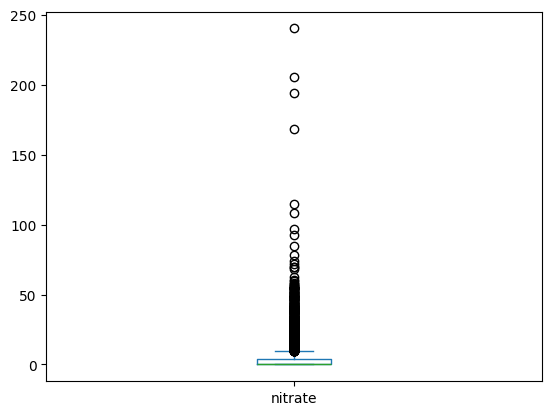

In [194]:
df[["nitrate"]].plot(kind = "box")

## Test / train split

In [195]:
outlier_method = "manual_removal"
top_nitrate_outliers = list(df["nitrate"].sort_values()[-50:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

3786

In [196]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 3170
Test: 616


<Axes: >

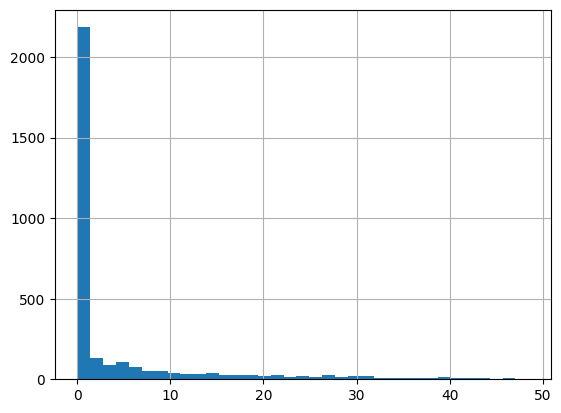

In [197]:
train_df['nitrate'].hist(bins=35)

<Axes: >

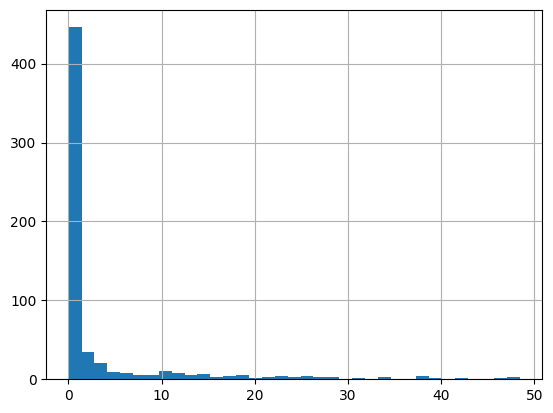

In [198]:
test_df['nitrate'].hist(bins=35)

## Outliers

In [199]:
# def get_outlier_mask(s, method='iqr', factor=1.5, z_thresh=3, mad_thresh=3.5, 
#                      lower_pct=0.01, upper_pct=0.99, contamination=0.01, X=None, 
#                      dbscan_eps=0.5, dbscan_min_samples=5, domain_range=None):

#     if method == 'iqr':
#         q1, q3 = s.quantile([0.25, 0.75])
#         iqr = q3 - q1
#         lower, upper = q1 - factor * iqr, q3 + factor * iqr
#         return (s >= lower) & (s <= upper)

#     elif method == 'zscore':
#         z = zscore(s, nan_policy='omit')
#         return np.abs(z) < z_thresh

#     elif method == 'mad':
#         median = np.median(s)
#         mad = robust.mad(s)
#         z = 0.6745 * (s - median) / mad if mad else np.zeros_like(s)
#         return np.abs(z) < mad_thresh

#     elif method == 'percentile':
#         lower, upper = s.quantile([lower_pct, upper_pct])
#         return (s >= lower) & (s <= upper)

#     elif method == 'isoforest':
#         if X is None: raise ValueError("X (DataFrame) required for Isolation Forest.")
#         iso = IsolationForest(contamination=contamination, random_state=42)
#         outlier_pred = iso.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'lof':
#         if X is None: raise ValueError("X (DataFrame) required for LOF.")
#         lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
#         outlier_pred = lof.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'dbscan':
#         if X is None: raise ValueError("X (DataFrame) required for DBSCAN.")
#         db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
#         return db.labels_ != -1

#     elif method == 'domain':
#         if domain_range is None: raise ValueError("Specify domain_range=(min, max) for 'domain' method.")
#         lower, upper = domain_range
#         return (s >= lower) & (s <= upper)

#     else:
#         raise ValueError(f"Unknown outlier removal method: {method}")


# outlier_method = "iqr"  # or "zscore", "mad", "percentile", "isoforest", etc.
# lower, upper = 0, 100
# domain_range=(lower, upper)

# # Univariate example (apply only to train, get bounds, then apply same to test)
# mask_train = get_outlier_mask(train_df['nitrate'], method=outlier_method, X=train_df)
# lb, ub = train_df.loc[mask_train, 'nitrate'].min(), train_df.loc[mask_train, 'nitrate'].max()  # For some methods, like IQR

# train_df = train_df[mask_train]
# test_df = test_df[(test_df['nitrate'] >= lb) & (test_df['nitrate'] <= ub)]
# # test_df_new = test_df_new[(test_df_new['nitrate'] >= lb) & (test_df_new['nitrate'] <= ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")
# # print(f"Test New rows after outlier filter: {len(test_df_new):,}")


In [200]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [201]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [202]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']


In [203]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", MinMaxScaler(), numerical_cols)
])

## Initialize model

In [204]:
xgb_reg = xgb.XGBRegressor(
        objective="reg:squarederror",
        learning_rate=0.05,
        n_estimators=2000,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=4,
        n_jobs=-1
)

In [205]:
number_of_features = 15
selector = SelectFromModel(xgb.XGBRegressor(n_estimators=number_of_features, random_state=123), threshold="median")

In [206]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("selector", selector),
    ("xgb", xgb_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe
    # func=np.log1p,
    # inverse_func=np.expm1
)

In [207]:
# param_dist = {
#     "regressor__xgb__n_estimators": [30, 50, 100],
#     "regressor__xgb__max_depth": [5, 7, 8],
#     "regressor__xgb__learning_rate": [0.01, 0.05, 0.1],
#     "regressor__xgb__subsample": [0.6, 0.8, 1.0],
#     "regressor__xgb__colsample_bytree": [0.3, 0.4, 0.6]
# }

# param_dist = {
#     "regressor__xgb__learning_rate"    : [0.005, 0.01, 0.03, 0.05],
#     "regressor__xgb__max_depth"        : [6, 8, 10],
#     "regressor__xgb__min_child_weight" : [0.3, 0.5, 1],
#     "regressor__xgb__subsample"        : [0.4, 0.6],
#     "regressor__xgb__colsample_bytree" : [0.6, 0.8, 1.0],
#     "regressor__xgb__gamma"            : [0.1, 0.3],
#     "regressor__xgb__reg_lambda"       : [1.0, 5.0, 6.0],
#     "regressor__xgb__n_estimators"     : [100, 125, 150]
# }

# param_dist = {
#     'regressor__xgb__n_estimators': [100, 300, 400, 500],
#     'regressor__xgb__max_depth': [7, 10, 12],
#     'regressor__xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'regressor__xgb__subsample': [0.7, 0.8, 1.0],
#     'regressor__xgb__colsample_bytree': [0.5, 0.7, 1.0],
#     'regressor__xgb__min_child_weight': [1, 3, 5, 7],
#     'regressor__xgb__gamma': [0, 0.1, 0.3, 1],
#     'regressor__xgb__reg_alpha': [0, 0.01, 0.1, 1],
#     'regressor__xgb__reg_lambda': [1, 1.5, 2, 5],
# }

# param_dist = {
#     'regressor__xgb__n_estimators': [150, 250, 300],
#     'regressor__xgb__max_depth': [5, 7, 9],
#     'regressor__xgb__learning_rate': [0.03, 0.05, 0.07],
#     'regressor__xgb__subsample': [0.75, 0.8, 0.85],
#     'regressor__xgb__colsample_bytree': [0.6, 0.7, 0.8],
#     'regressor__xgb__min_child_weight': [1, 2, 3],
#     'regressor__xgb__gamma': [0, 0.05, 0.1],
#     'regressor__xgb__reg_alpha': [0.05, 0.1, 0.2],
#     'regressor__xgb__reg_lambda': [3, 5, 7],
# }

param_grid = {
    'regressor__xgb__n_estimators': [300, 400, 500, 550, 600],
    'regressor__xgb__max_depth': [3, 4, 6, 8],
    'regressor__xgb__min_child_weight': [0.01, 0.03, 0.05, 0.1],
    'regressor__xgb__gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'regressor__xgb__subsample': [0.6, 0.8, 1.0],
    'regressor__xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'regressor__xgb__alpha': [0, 0.01, 0.05, 0.1],
    'regressor__xgb__lambda': [1, 5, 10],
    'regressor__xgb__grow_policy': ['depthwise', 'lossguide']
}

# param_grid = {
#     'regressor__xgb__n_estimators': [300, 400],  # keep lower
#     'regressor__xgb__max_depth': [3, 4],
#     'regressor__xgb__min_child_weight': [0.05, 0.1],
#     'regressor__xgb__gamma': [0.2, 0.3],
#     'regressor__xgb__subsample': [0.6, 0.8],
#     'regressor__xgb__colsample_bytree': [0.5, 0.6],
#     'regressor__xgb__alpha': [0.05, 0.1],
#     'regressor__xgb__lambda': [5, 10],
#     'regressor__xgb__grow_policy': ['lossguide']
# }


## Hyperparameter tuning

In [208]:
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=tscv,
    # scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    scoring=scoring,                # <-- dictionary!
    refit='R2',                     # <-- which metric to optimize
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [209]:
print("Best CV MAE:", search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.5509511040280168
Best params: {'regressor__xgb__subsample': 0.6, 'regressor__xgb__n_estimators': 500, 'regressor__xgb__min_child_weight': 0.01, 'regressor__xgb__max_depth': 8, 'regressor__xgb__lambda': 1, 'regressor__xgb__grow_policy': 'lossguide', 'regressor__xgb__gamma': 0, 'regressor__xgb__colsample_bytree': 0.8, 'regressor__xgb__alpha': 0.05}


In [210]:
# # save model

# import joblib
# joblib.dump(best_model, '../../trained_models/new_xgb_notebook.pkl')

['../../trained_models/new_xgb_notebook.pkl']

## Learning curve

In [211]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [212]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=10)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)

        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))


KeyboardInterrupt: 

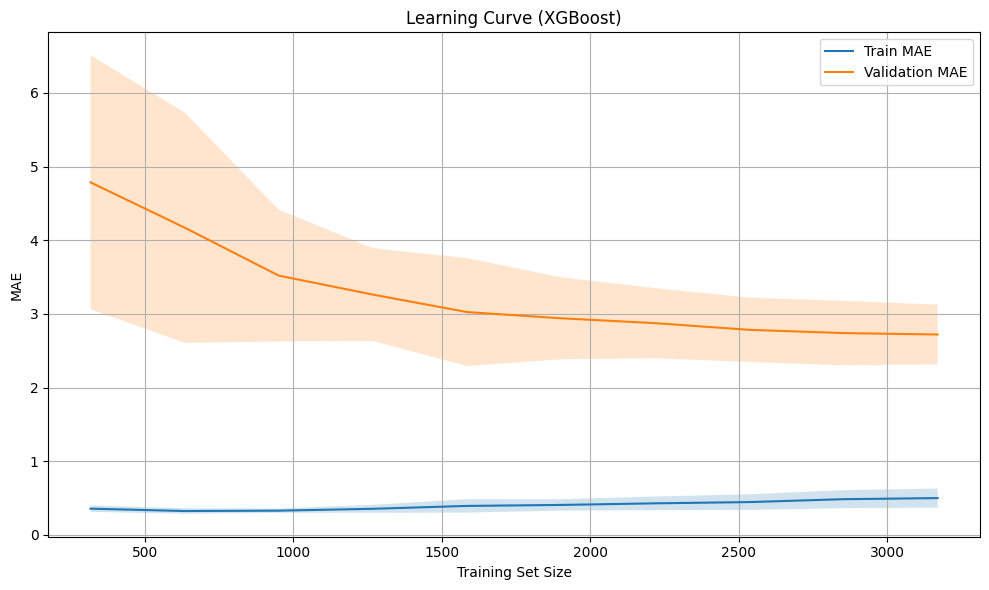

In [136]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

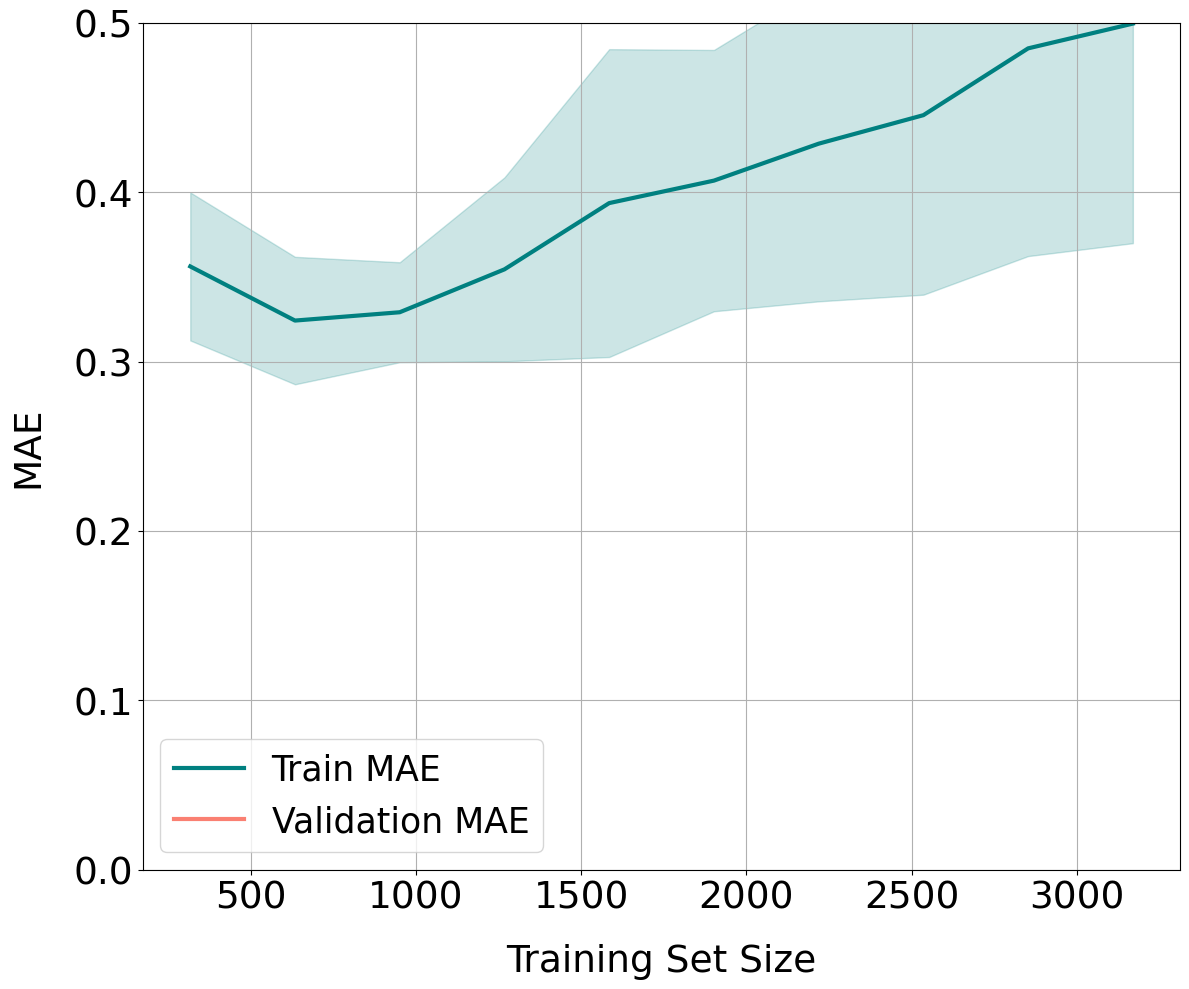

In [137]:
import matplotlib.pyplot as plt

train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

# Plot lines with custom colors
plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

# Increase font sizes
plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 0.5)  # Set fixed y-axis range
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model

In [138]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'ac...
                                                                   feature_types=None,
                                                                   gamma=0.2,
                                                                   grow_policy='depthwise',
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   lambda=10,
                                                                   learning_rate=0.05,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=8,
                                                                   max_leaves=None,
                                                                   min_child_weight=0.05,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=400,
                                                                   n_jobs=-1, ...))]))

## Final Train score

In [139]:
pred_train = best_model.predict(X_train)

train_r2 = r2_score(y_train, pred_train)
train_mae = mean_absolute_error(y_train, pred_train)
train_rmse = sqrt(mean_squared_error(y_train, pred_train))

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9664162059441714
Train MAE: 0.7654250108918558
Test RMSE: 1.6087423836778367


## Final Test score

In [140]:
pred_nitrate = best_model.predict(X_test)

test_r2 = r2_score(y_test, pred_nitrate)
test_mae = mean_absolute_error(y_test, pred_nitrate)
test_rmse = sqrt(mean_squared_error(y_test, pred_nitrate))

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Test R2: 0.5680933143489155
Test MAE: 2.6351313053409813
Test RMSE: 5.599287083440437


In [141]:
pd.Series(pred_nitrate).to_csv('test_pred_nitrate_xgb.csv', index=False)

## Calibration

In [142]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(pred_nitrate.reshape(-1, 1), y_test)

# Apply calibration to predictions
y_calibrated = lr.predict(pred_nitrate.reshape(-1, 1))

In [143]:
calib_test_r2 = r2_score(y_test, y_calibrated)
calib_test_mae = mean_absolute_error(y_test, y_calibrated)
calib_test_rmse = sqrt(mean_squared_error(y_test, y_calibrated))

print("Test R2:", calib_test_r2)
print("Test MAE:", calib_test_mae)
print("Test RMSE:", calib_test_rmse)

Test R2: 0.5682747445000682
Test MAE: 2.6444169083992866
Test RMSE: 5.598110919418596


## Real vs Predicted

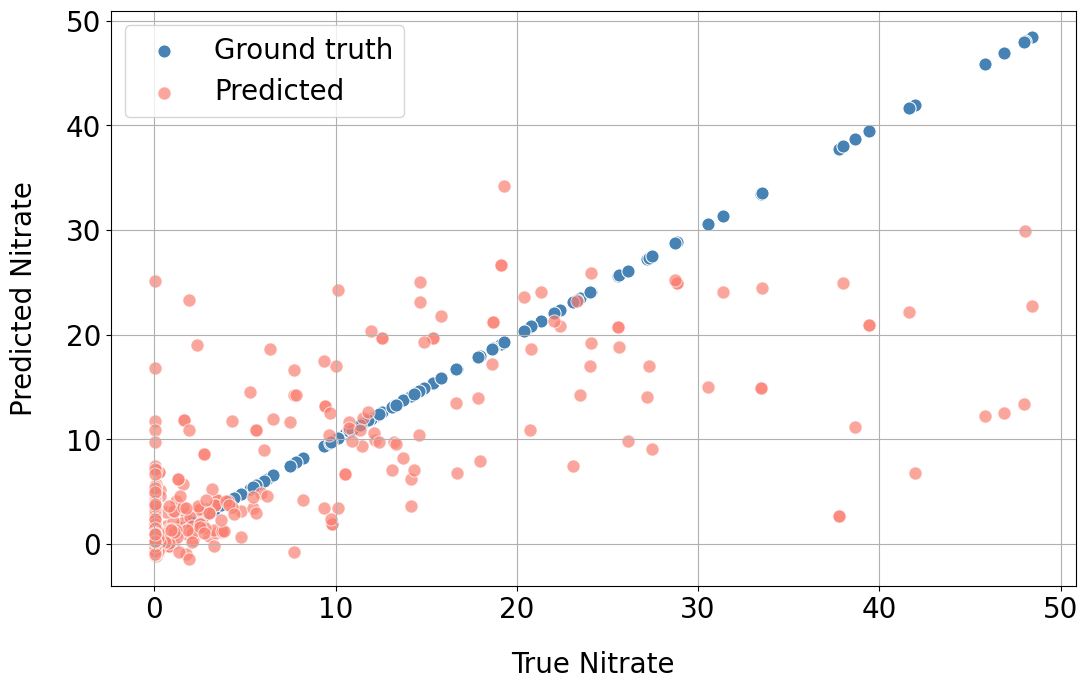

In [144]:
fig, ax = plt.subplots(figsize=(11, 7))

# Ground truth (diagonal reference line)
sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")

# Model predictions
sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

# Labels and style
ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()


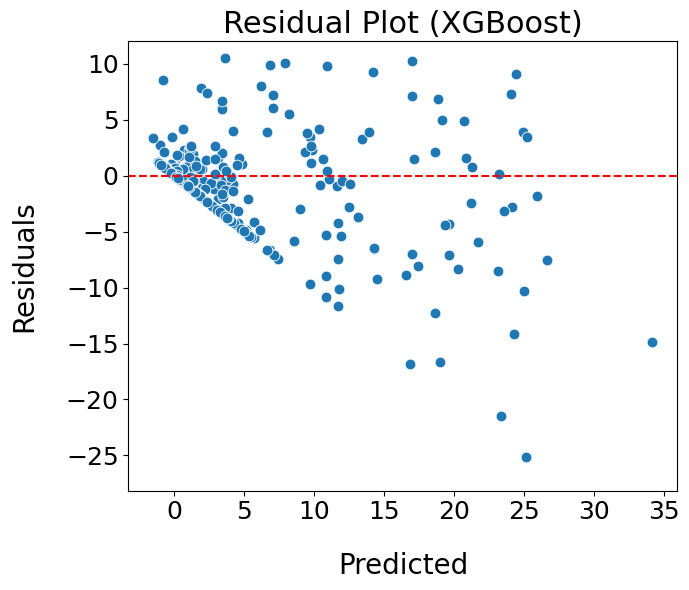

In [145]:
preds = best_model.predict(X_test)

residuals = y_test - preds
plt.figure(figsize=(7, 6))

sns.scatterplot(x=preds, y=residuals, s=60)

plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted", fontsize=20, labelpad=20)
plt.ylabel("Residuals", fontsize=20, labelpad=20)
plt.title("Residual Plot (XGBoost)", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(top=12)
plt.tight_layout()
plt.show()

In [146]:
residuals.to_csv("xgb_residuals.csv")

## Predictions on the map

In [147]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

616
616
616
616


In [148]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

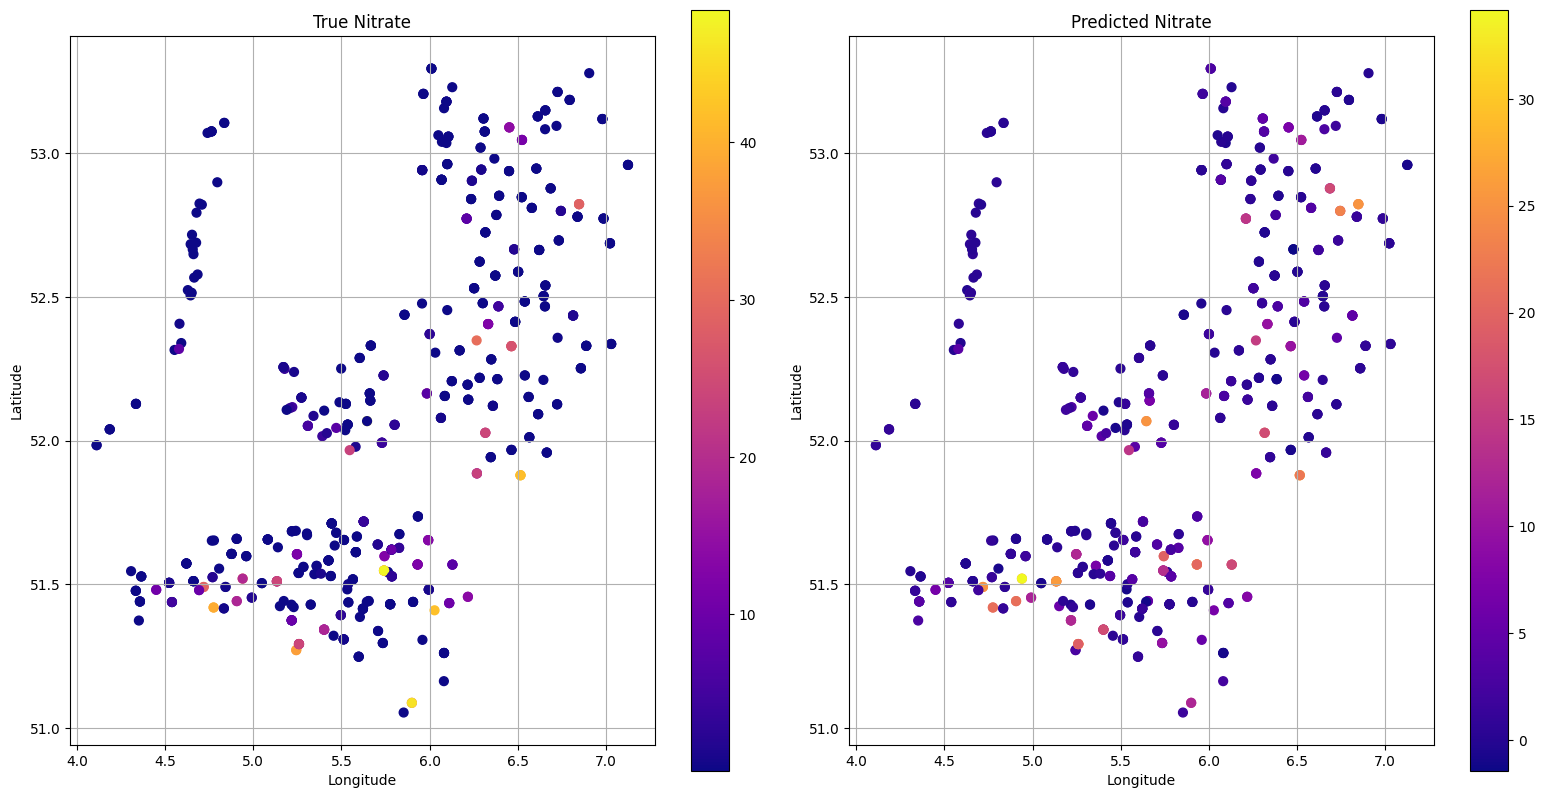

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

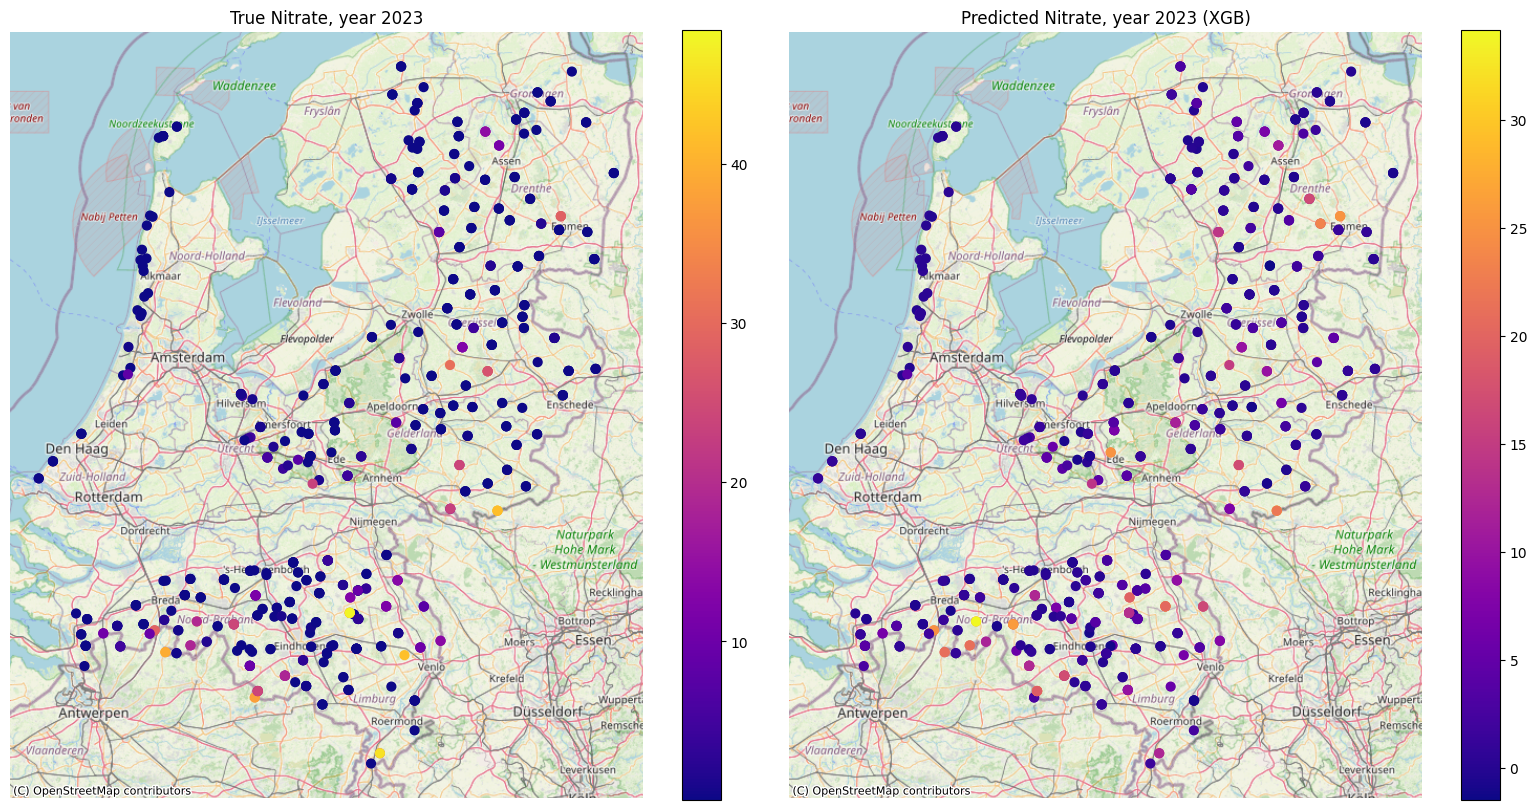

In [150]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (XGB)")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

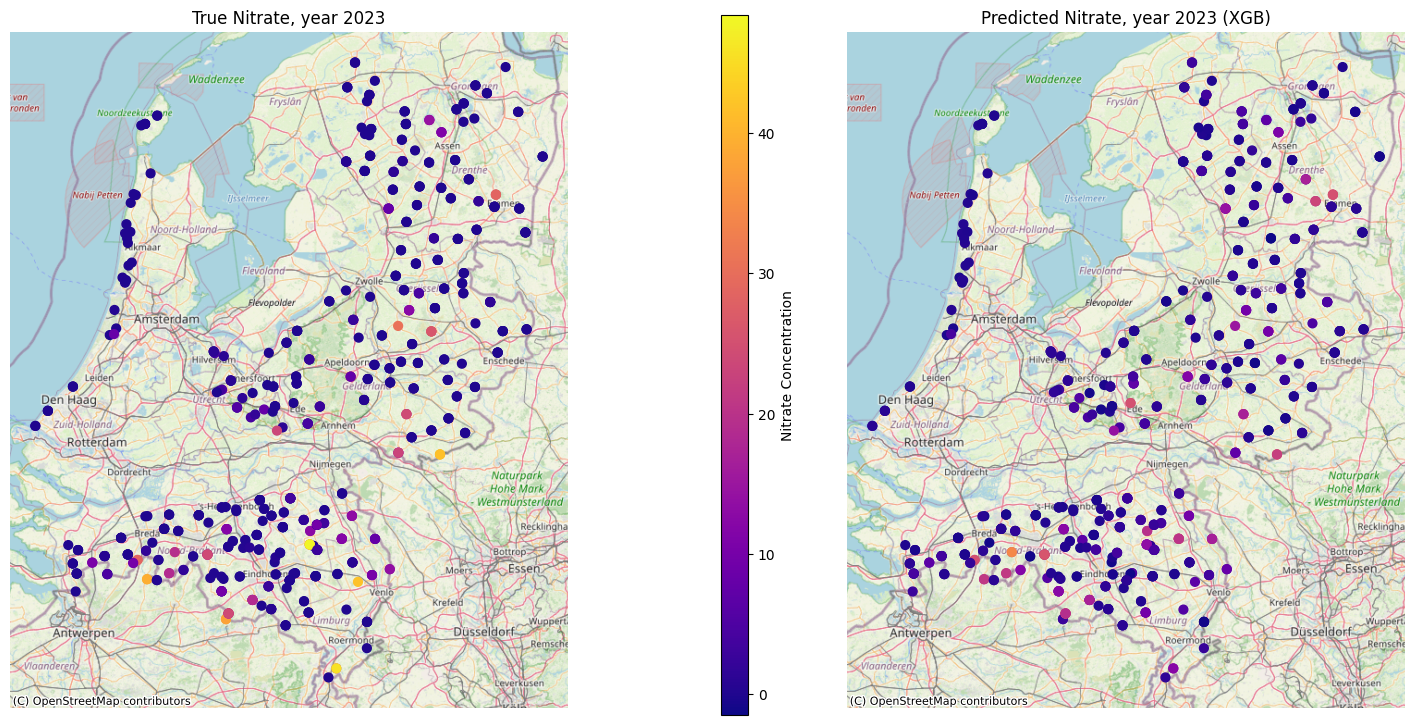

In [151]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Reproject
gdf_3857 = gdf.to_crs(epsg=3857)

# Shared color range
vmin = min(gdf_3857["nitrate_true"].min(), gdf_3857["nitrate_pred"].min())
vmax = max(gdf_3857["nitrate_true"].max(), gdf_3857["nitrate_pred"].max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={"wspace": 0.5})  # less space between plots

# Plot
gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (XGB)")

for ax in axs:
    ax.set_axis_off()

# Add colorbar BETWEEN the subplots
cbar_ax = fig.add_axes([0.52, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label="Nitrate Concentration")

plt.show()


## Logging

In [152]:
curr_dir = os.getcwd()
log_path = os.path.join(curr_dir, '../../logging/experiment_log.json')

# After each notebook run, do this!
logger = ExperimentLogger(save_path=log_path)

# if not outlier_method:

model = "XGBoost"
hyperparams = search.best_params_
outlier_method = None
train_score = {"R2": train_r2, "MAE": train_mae, "RMSE": train_rmse}
test_score = {"R2": test_r2, "MAE": test_mae, "RMSE": test_rmse}
data_file_name = data_path

logger.log(
    model = model,
    data_file = data_file_name,
    features = number_of_features,
    hyperparams=hyperparams,
    outlier_method=outlier_method,
    train_score=train_score,
    test_score=test_score,
    extra_info={"note": "Removed soil region"}
)

{'model': 'XGBoost',
 'data_file': '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/notebooks/models/../../data/aligned/merged_dataset_1_ahn_elevation.csv',
 'features': 15,
 'timestamp': '2025-07-13T10:36:11.549815',
 'hyperparameters': {'regressor__xgb__subsample': 0.8,
  'regressor__xgb__n_estimators': 400,
  'regressor__xgb__min_child_weight': 0.05,
  'regressor__xgb__max_depth': 8,
  'regressor__xgb__lambda': 10,
  'regressor__xgb__grow_policy': 'depthwise',
  'regressor__xgb__gamma': 0.2,
  'regressor__xgb__colsample_bytree': 0.5,
  'regressor__xgb__alpha': 0},
 'outlier_method': None,
 'train_score': {'R2': 0.9664162059441714,
  'MAE': 0.7654250108918558,
  'RMSE': 1.6087423836778367},
 'test_score': {'R2': 0.5680933143489155,
  'MAE': 2.6351313053409813,
  'RMSE': 5.599287083440437},
 'note': 'Removed soil region'}

## Interpretability

In [153]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'ac...
                                                                   feature_types=None,
                                                                   gamma=0.2,
                                                                   grow_policy='depthwise',
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   lambda=10,
                                                                   learning_rate=0.05,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=8,
                                                                   max_leaves=None,
                                                                   min_child_weight=0.05,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=400,
                                                                   n_jobs=-1, ...))]))

In [154]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [155]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['xgb']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [156]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

ValueError: All arrays must be of the same length

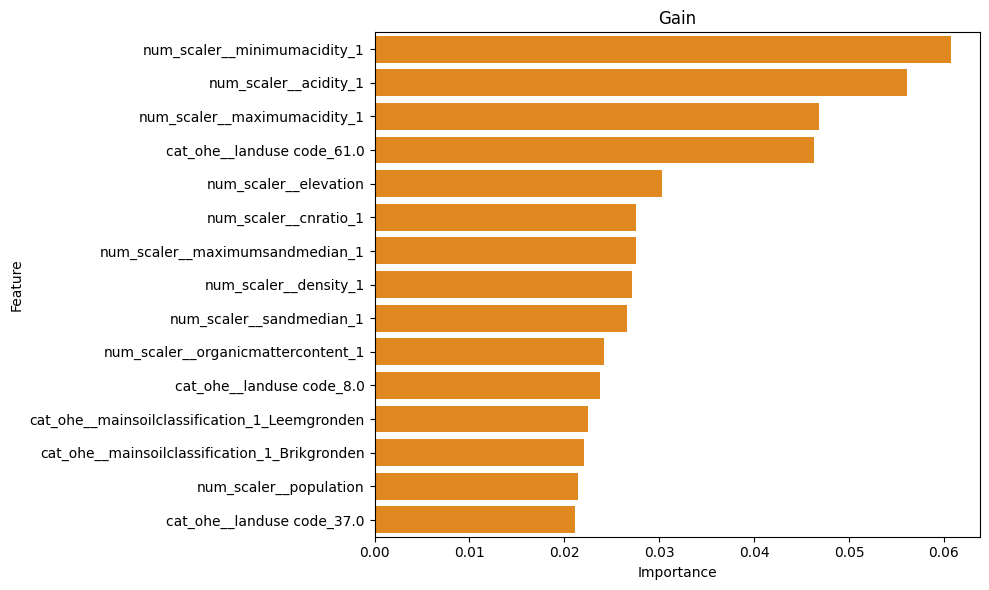

In [1567]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [1568]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

# importance_types = ["gain", "cover", "weight"]
importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [1569]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

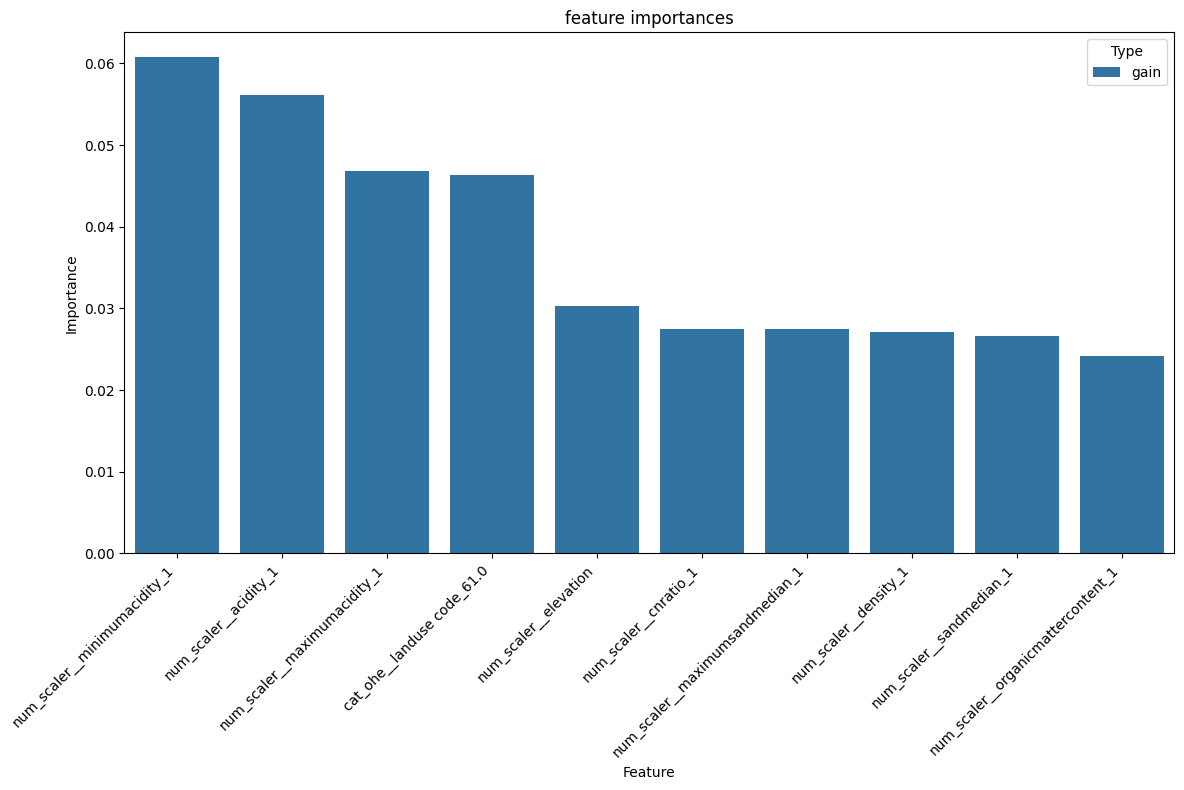

In [1570]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


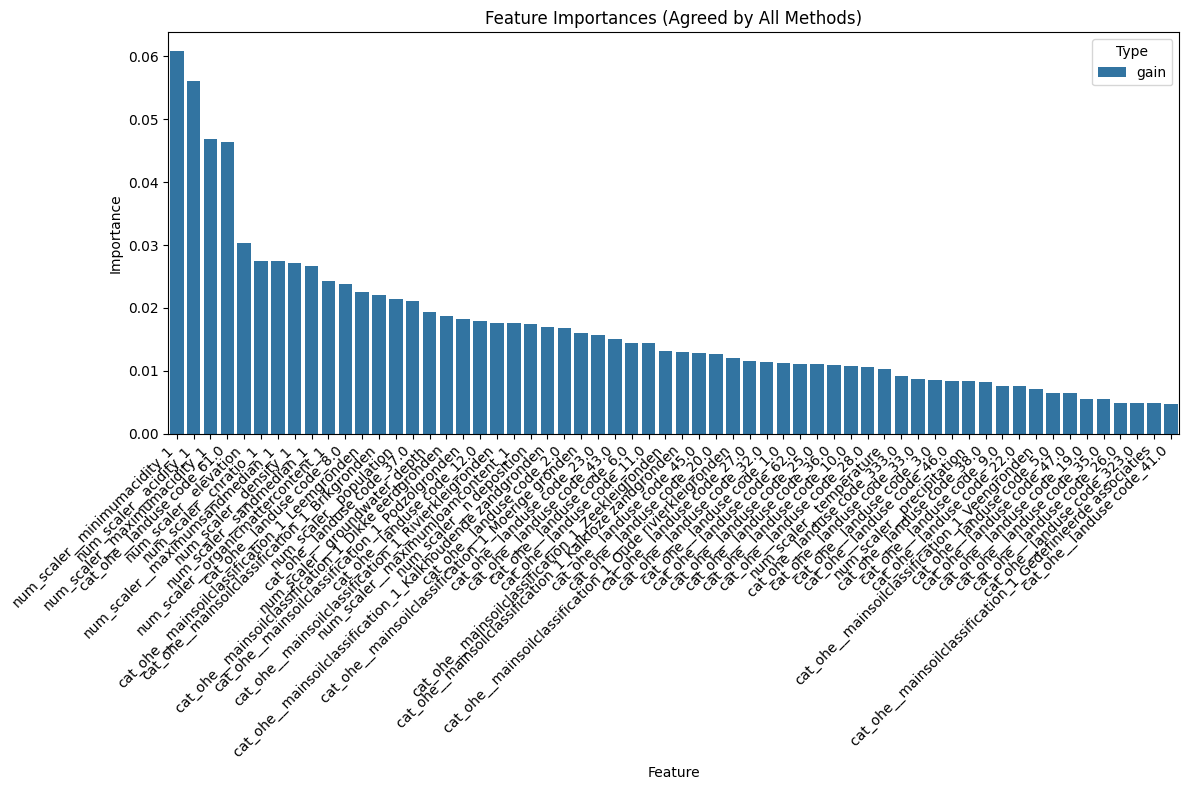

In [1571]:
# Step 1: List all feature types (e.g., importance methods)
methods = importances_df["Type"].unique()

# Step 2: Count how many methods report each feature
feature_method_counts = (
    importances_df.groupby("Feature")["Type"]
    .nunique()
    .reset_index(name="method_count")
)

# Step 3: Keep only features that appear in all methods
consistent_features = feature_method_counts[
    feature_method_counts["method_count"] == len(methods)
]["Feature"]

# Step 4: Filter original dataframe to only these consistent features
consistent_df = importances_df[importances_df["Feature"].isin(consistent_features)]

# Step 5: Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=consistent_df.sort_values("Importance", ascending=False),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importances (Agreed by All Methods)")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [1572]:
assert fitted_model.n_features_in_ == len(feature_names)

In [1573]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

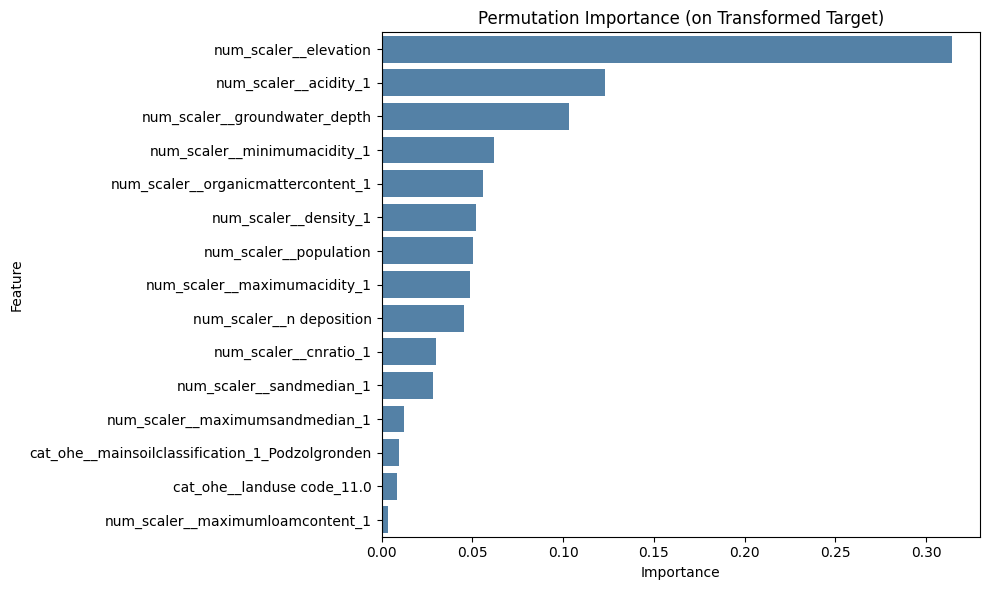

In [1574]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [1575]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [1576]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__landuse code_1.0,0.011326,gain,NaN
1,cat_ohe__landuse code_2.0,0.016844,gain,NaN
2,cat_ohe__landuse code_3.0,0.008549,gain,NaN
3,cat_ohe__landuse code_5.0,0.006496,gain,NaN
4,cat_ohe__landuse code_6.0,0.014415,gain,NaN
...,...,...,...,...
46,cat_ohe__mainsoilclassification_1_Moerige gronden,-0.000021,permutation,0.000091
43,cat_ohe__mainsoilclassification_1_Kalkhoudende...,-0.000371,permutation,0.000060
55,num_scaler__precipitation,-0.000972,permutation,0.001757
33,cat_ohe__landuse code_45.0,-0.001225,permutation,0.000808


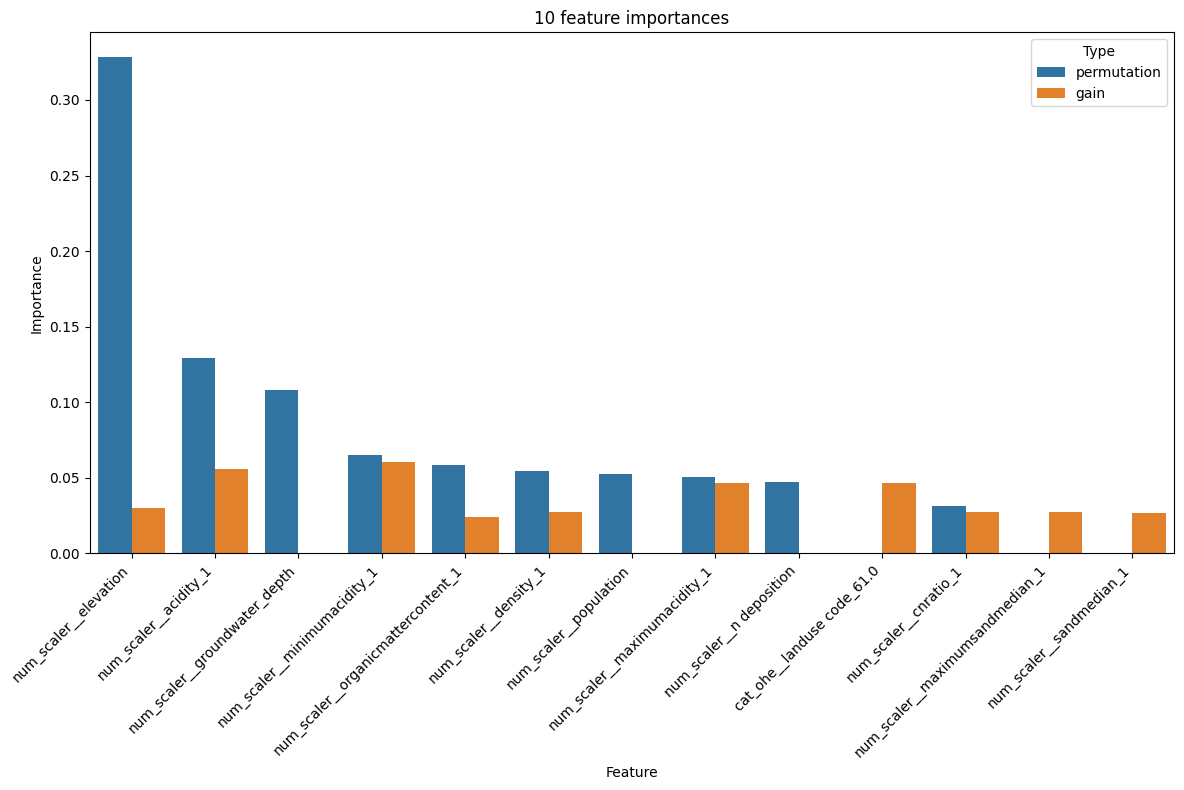

In [1577]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

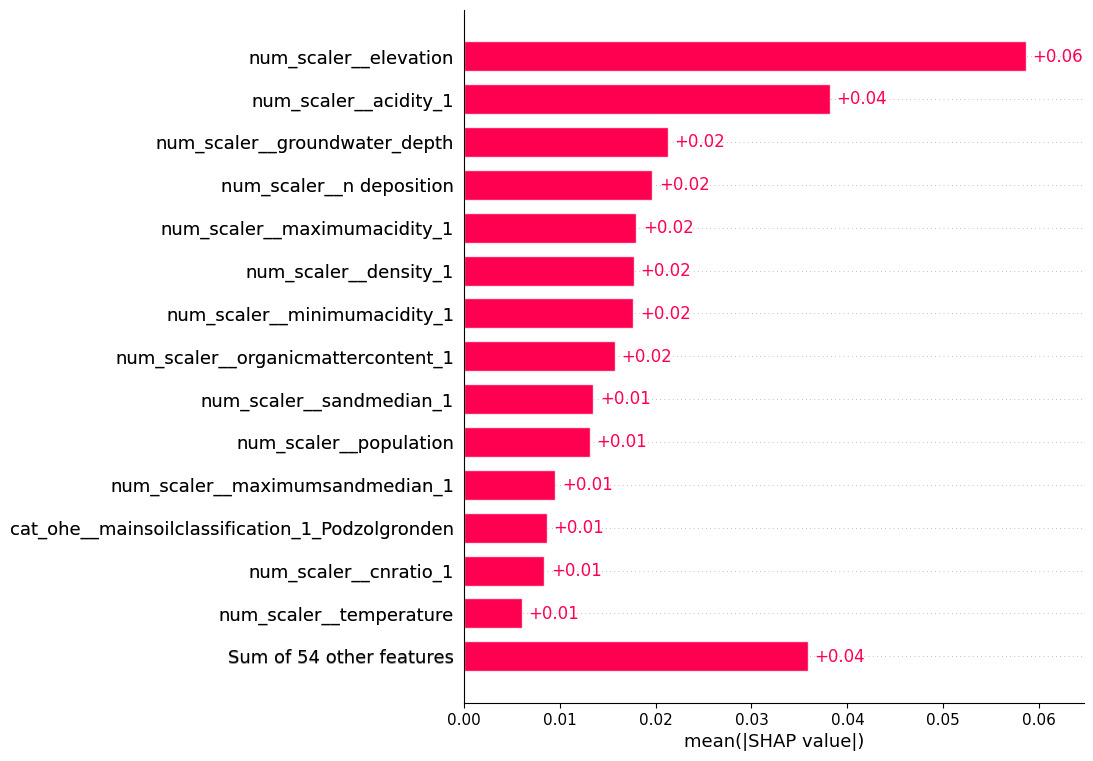

In [1578]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


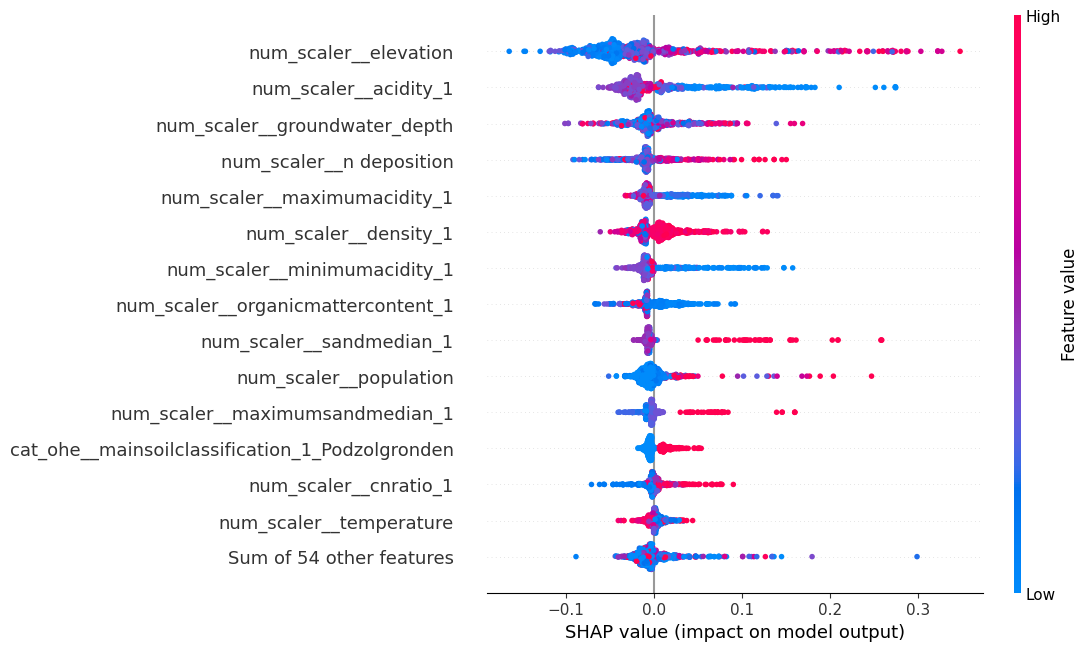

In [1579]:
shap.plots.beeswarm(shap_explanation, max_display=15)

In [1580]:
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": shap_mean_importance
}).sort_values("Importance", ascending=False)

shap_df["Importance"] /= shap_df["Importance"].sum()
shap_df["Type"] = "shap"


In [1581]:
perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"


In [1582]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    X_test_transformed_df.values,
    feature_names=feature_names,
    mode='regression',
    random_state=4
)

lime_weights = np.zeros(len(feature_names))
n_samples = 30

for i in range(n_samples):
    explanation = lime_explainer.explain_instance(
        X_test_transformed_df.values[i],
        fitted_model.predict,
        num_features=len(feature_names)
    )
    
    for feature_str, weight in explanation.as_list():
        # Match by checking which real feature name is included in LIME's string
        for j, fname in enumerate(feature_names):
            if fname in feature_str:
                lime_weights[j] += abs(weight)
                break  # stop at first match


lime_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lime_weights / lime_weights.sum(),
    "Type": "lime"
})

In [1583]:
combined_df = pd.concat([shap_df, perm_df, lime_df], ignore_index=True)
combined_df.to_csv("model-agnostic.csv")

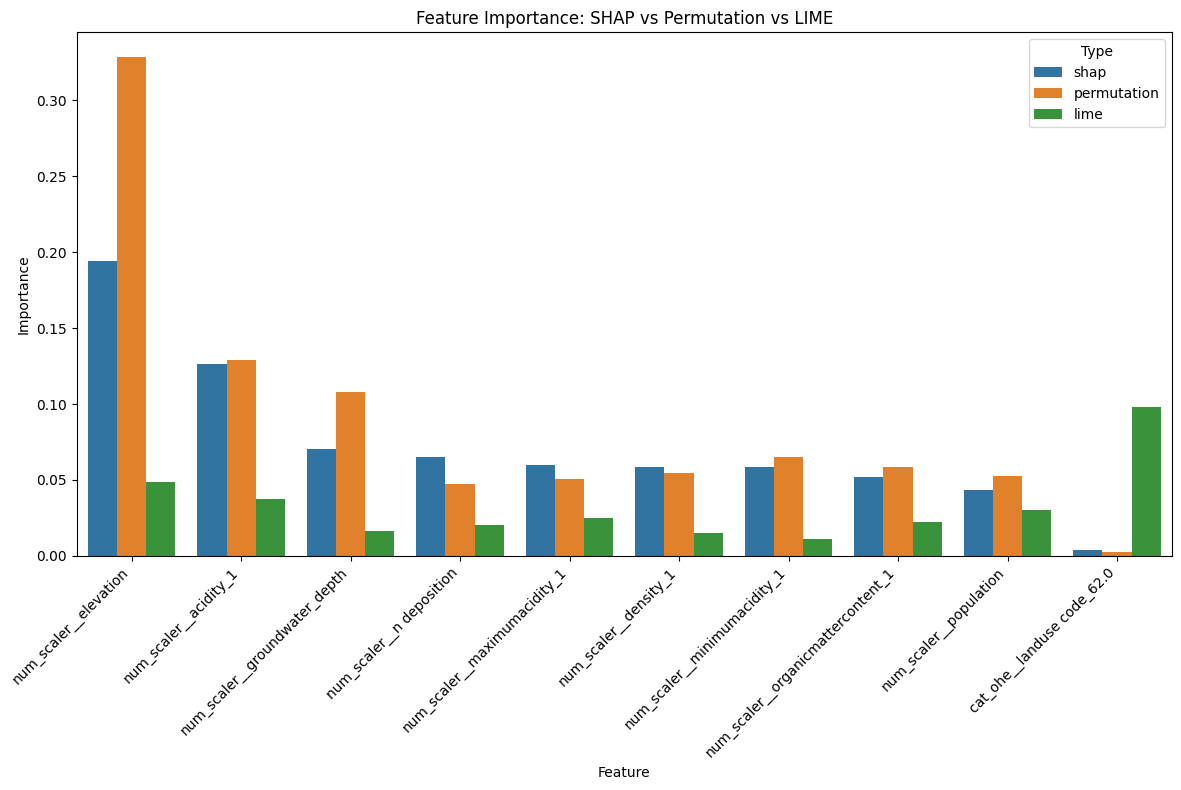

In [1584]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df[combined_df["Feature"].isin(
        combined_df.groupby("Feature")["Importance"].sum().nlargest(10).index
    )],
    x="Feature", y="Importance", hue="Type"
)
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.title("Feature Importance: SHAP vs Permutation vs LIME")
plt.tight_layout()
plt.show()
